In [1]:
#@title 1.1 Import libraries and tools
!pip install transformers

# Tools for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
#import torch

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import re

# Transformer tools
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

/Users/alex_z/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# import dataset

In [2]:
df = pd.read_csv('data_pre_labeled.csv')
df.head()

,title,link,date,source,country,language,translated_title,number_of_characters_title,number_of_words_title,day_of_week,...,score,level,emotion,anger,disgust,fear,joy,neutral,sadness,surprise
0,Iran uses Artificial Intelligence for maximizi...,https://news.google.com/rss/articles/CBMigAFod...,2023-05-07,ANI News,US,en,Iran uses Artificial Intelligence for maximizi...,70,11,Sunday,...,0.988586,1,neutral,0.112523,0.042290,0.027945,0.011075,0.720948,0.023412,0.061808
1,Mortgage Lenders See AI As Key To Operational ...,https://news.google.com/rss/articles/CBMiYGh0d...,2023-10-09,National Mortgage Professional,US,en,Mortgage Lenders See AI As Key To Operational ...,77,13,Monday,...,0.694418,4,neutral,0.012085,0.004010,0.007655,0.047238,0.835112,0.003112,0.090787
2,How the Threat of AI Coincided with the Writer...,https://news.google.com/rss/articles/CBMiX2h0d...,2023-10-04,The Spectator,US,en,How the Threat of AI Coincided with the Writer...,59,13,Wednesday,...,0.995044,1,fear,0.076509,0.009194,0.470964,0.020682,0.239871,0.016962,0.165819
3,Telex : Le code source du ransomware HelloKitt...,https://news.google.com/rss/articles/CBMiwgFod...,2023-10-09,Le Monde Informatique,US,fr,Telex: HelloKitty ransomware source code revea...,129,22,Monday,...,0.990982,1,neutral,0.051770,0.003407,0.088759,0.029821,0.674117,0.017902,0.134224
4,Is AI a Master or Slave? - Namibian,https://news.google.com/rss/articles/CBMiNGh0d...,2023-10-03,Namibian,US,en,Is AI a Master or Slave? - Namibian,28,8,Tuesday,...,0.998335,1,neutral,0.041249,0.182959,0.014104,0.002632,0.689008,0.011997,0.058050


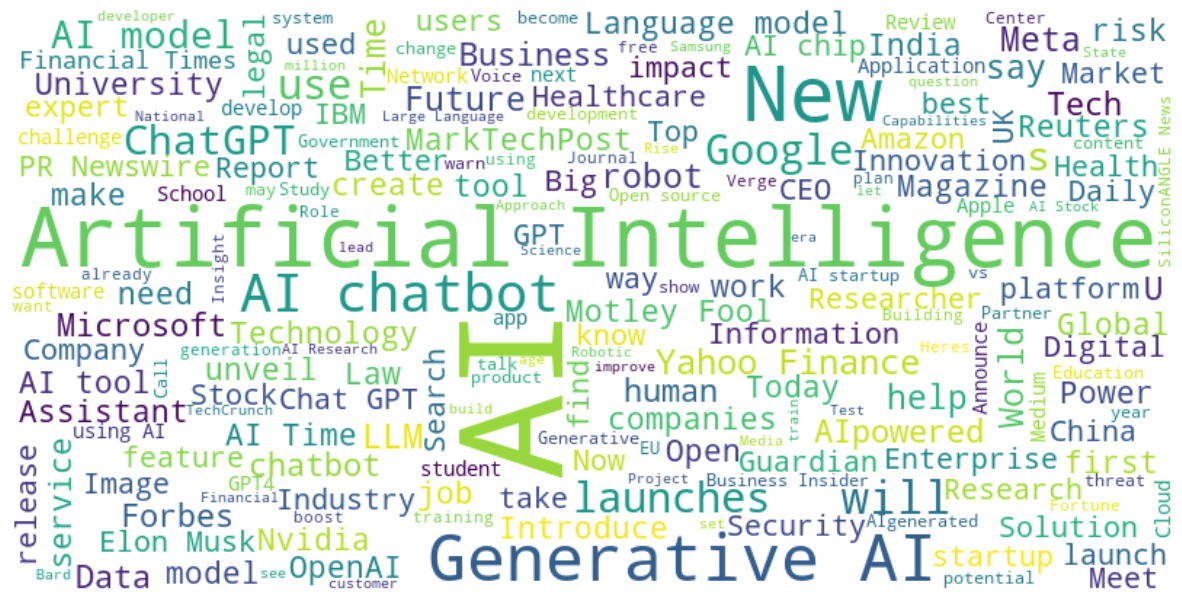

In [70]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import string
from collections import defaultdict

stopwords = set(STOPWORDS)
# Function to map words back to their most common case
def map_words_to_most_common_case(words):
    word_case_map = defaultdict(list)
    # Create a dictionary where the key is the word in lowercase
    # and the value is a list of cases that word appears in
    for word in words:
        word_case_map[word.lower()].append(word)

    # Choose the most common case for each word
    most_common_case_map = {word.lower(): max(set(cases), key=cases.count) for word, cases in word_case_map.items()}
    return most_common_case_map

# Extract titles, split into words and flat the list
words = ' '.join(df['translated_title'].dropna().astype(str)).split()

# Get the most common case for each word
most_common_case_map = map_words_to_most_common_case(words)

# Replace words in the original text with the most common case
normalized_text = ' '.join(most_common_case_map.get(word.lower(), word) for word in words)

# Remove punctuation (using a simple string translate)
normalized_text = normalized_text.translate(str.maketrans('', '', string.punctuation))

# Generate the word cloud without lowercasing the text
wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_font_size=100,
    stopwords=stopwords
).generate(normalized_text)

# Display the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Perform Analysis

In [3]:
df_label = df['label']
df_label.head()

0    NEGATIVE
1    POSITIVE
2    NEGATIVE
3    NEGATIVE
4    NEGATIVE
Name: label, dtype: object

## 1. 1Most dominant word for each label

In [4]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Add a new column for the month
df['month'] = df['date'].dt.to_period('M')
df.month

0       2023-05
1       2023-10
2       2023-10
3       2023-10
4       2023-10
         ...   
3495    2023-11
3496    2023-10
3497    2023-11
3498    2023-06
3499    2023-06
Name: month, Length: 3500, dtype: period[M]

In [5]:
# Remove stopwords and tokenize the headlines
stop_words = set(stopwords.words('english'))
df['tokenized_title'] = df['translated_title'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.isalnum() and word.lower() not in stop_words])

# Define a mapping of synonymous words
synonymous_mapping = {'artificial intelligence': 'ai', 'machine learning': 'ml','artificial': 'ai', 'intelligence': 'ai',}  # Add more as needed

# Function to replace synonymous words
def replace_synonymous(tokenized_headlines, mapping):
    return [mapping.get(word, word) for word in tokenized_headlines]

# Apply the mapping to the tokenized headlines
df['tokenized_title'] = df['tokenized_title'].apply(lambda x: replace_synonymous(x, synonymous_mapping))


In [6]:
# Filter by sentiment label
positive_df = df[df['label'] == 'POSITIVE']
negative_df = df[df['label'] == 'NEGATIVE']

In [7]:
# Function to get the top 3 words from a list of tokenized headlines
def get_top_words(tokenized_headlines, top_n=10):
    word_counts = Counter(tokenized_headlines)
    return word_counts.most_common(top_n)

In [8]:
# Get top 3 words for each month and sentiment
top_positive_words_by_month = positive_df.groupby(['month'])['tokenized_title'].apply(lambda x: get_top_words(x.sum())).reset_index()
top_negative_words_by_month = negative_df.groupby(['month'])['tokenized_title'].apply(lambda x: get_top_words(x.sum())).reset_index()

In [9]:
# Print the results
print("Top 3 positive words by month:")
print(top_positive_words_by_month)

print("\nTop 3 negative words by month:")
print(top_negative_words_by_month)

Top 3 positive words by month:
     month                                    tokenized_title
0  2023-05  [(ai, 103), (google, 13), (generative, 10), (b...
1  2023-06  [(ai, 142), (generative, 23), (new, 13), (news...
2  2023-07  [(ai, 137), (generative, 17), (new, 10), (news...
3  2023-08  [(ai, 183), (generative, 23), (new, 20), (meta...
4  2023-09  [(ai, 172), (generative, 14), (chatbot, 14), (...
5  2023-10  [(ai, 475), (generative, 62), (new, 50), (news...
6  2023-11  [(ai, 546), (generative, 55), (new, 45), (laun...

Top 3 negative words by month:
     month                                    tokenized_title
0  2023-05  [(ai, 117), (news, 15), (google, 13), (chatbot...
1  2023-06  [(ai, 234), (chatbot, 22), (news, 19), (chatgp...
2  2023-07  [(ai, 189), (news, 20), (chatbot, 17), (google...
3  2023-08  [(ai, 226), (generative, 23), (chatbot, 20), (...
4  2023-09  [(ai, 244), (chatbot, 20), (generative, 16), (...
5  2023-10  [(ai, 625), (generative, 57), (news, 43), (new...
6  2023

## 1.2 Most dominant themes

In [10]:
data_theme = df[['translated_title']]
data_theme.head()

,translated_title
0,Iran uses Artificial Intelligence for maximizi...
1,Mortgage Lenders See AI As Key To Operational ...
2,How the Threat of AI Coincided with the Writer...
3,Telex: HelloKitty ransomware source code revea...
4,Is AI a Master or Slave? - Namibian


In [11]:
#!pip install gensim

In [12]:
from nltk.stem.porter import PorterStemmer
from gensim.parsing.preprocessing import strip_tags, strip_punctuation
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

In [13]:
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

def preprocess_text(text):
    # Remove irrelevant signs
    text = strip_tags(strip_punctuation(text))
    # Simplify words and remove stop words
    tokens = [porter.stem(token) for token in simple_preprocess(text, deacc=True) if token not in stop_words]
    return tokens

# Apply pre-processing
data_theme['processed_titles'] = data_theme['translated_title'].map(preprocess_text)

/var/folders/91/h7jl21mj6396j46wvh4vk1f40000gn/T/ipykernel_82797/1913487984.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_theme['processed_titles'] = data_theme['translated_title'].map(preprocess_text)


In [14]:
data_theme['month'] = df[['month']]

# Create an empty dictionary to store top words for each month and topic
top_words_by_month_topic = {}

/var/folders/91/h7jl21mj6396j46wvh4vk1f40000gn/T/ipykernel_82797/453478969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_theme['month'] = df[['month']]


In [15]:
# Loop through each month
for month in data_theme['month'].unique():
    # Filter data for the current month
    current_month_data = data_theme[data_theme['month'] == month]
    
    # Apply pre-processing
    current_month_data['processed_titles'] = current_month_data['translated_title'].map(preprocess_text)
    
    # Create dictionary
    dictionary = Dictionary(current_month_data['processed_titles'])
    
    # Create corpus library
    corpus = [dictionary.doc2bow(text) for text in current_month_data['processed_titles']]
    
    # Set theme number
    num_topics = 4
    
    # Train LDA model
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    
    # Get the top 3 dominant words for each topic
    top_words_by_topic = {}
    for idx, topic in lda_model.print_topics(-1):
        top_words = [word.split('*')[1].strip().strip('"') for word in topic.split('+')[:3]]
        top_words_by_topic[idx] = top_words
    
    # Store the results in the dictionary
    top_words_by_month_topic[month] = top_words_by_topic

# Print the results
for month, topics in top_words_by_month_topic.items():
    print(f"\nMonth: {month}")
    for topic, top_words in topics.items():
        print(f"Topic {topic}: {', '.join(top_words)}")

/var/folders/91/h7jl21mj6396j46wvh4vk1f40000gn/T/ipykernel_82797/1454339582.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_month_data['processed_titles'] = current_month_data['translated_title'].map(preprocess_text)



Month: 2023-05
Topic 0: ai, intellig, artifici
Topic 1: ai, news, chatbot
Topic 2: ai, robot, futur
Topic 3: ai, googl, gener

Month: 2023-10
Topic 0: ai, educ, must
Topic 1: intellig, artifici, webster
Topic 2: ai, space, hp
Topic 3: ai, gener, pc

Month: 2023-07
Topic 0: ai, gener, chatbot
Topic 1: ai, gpt, gener
Topic 2: artifici, intellig, ai
Topic 3: ai, artifici, intellig

Month: 2023-11
Topic 0: artifici, intellig, ai
Topic 1: ai, gener, news
Topic 2: ai, use, new
Topic 3: ai, musk, busi

Month: 2023-09
Topic 0: ai, nvidia, power
Topic 1: ai, chatbot, chatgpt
Topic 2: artifici, intellig, ai
Topic 3: ai, gpt, news

Month: 2023-08
Topic 0: ai, gener, artifici
Topic 1: ai, gener, model
Topic 2: intellig, artifici, ai
Topic 3: ai, make, chatbot

Month: 2023-06
Topic 0: ai, chatbot, use
Topic 1: ai, intellig, artifici
Topic 2: ai, artifici, intellig
Topic 3: ai, intellig, artifici


In [74]:
raw_data = {
    "2023-05": {
        "Topic 0": "ai, intellig, artifici",
        "Topic 1": "ai, news, chatbot",
        "Topic 2": "ai, robot, futur",
        "Topic 3": "ai, googl, gener"
    },
    "2023-10": {
        "Topic 0": "ai, educ, must",
        "Topic 1": "intellig, artifici, webster",
        "Topic 2": "ai, space, hp",
        "Topic 3": "ai, gener, pc"
    },
    "2023-07": {
        "Topic 0": "ai, gener, chatbot",
        "Topic 1": "ai, gpt, gener",
        "Topic 2": "artifici, intellig, ai",
        "Topic 3": "ai, artifici, intellig"
    },
    "2023-11": {
        "Topic 0": "artifici, intellig, ai",
        "Topic 1": "ai, gener, news",
        "Topic 2": "ai, use, new",
        "Topic 3": "ai, musk, busi"
    },
    "2023-09": {
        "Topic 0": "ai, nvidia, power",
        "Topic 1": "ai, chatbot, chatgpt",
        "Topic 2": "artifici, intellig, ai",
        "Topic 3": "ai, gpt, news"
    },
    "2023-08": {
        "Topic 0": "ai, gener, artifici",
        "Topic 1": "ai, gener, model",
        "Topic 2": "intellig, artifici, ai",
        "Topic 3": "ai, make, chatbot"
    },
    "2023-06": {
        "Topic 0": "ai, chatbot, use",
        "Topic 1": "ai, intellig, artifici",
        "Topic 2": "ai, artifici, intellig",
        "Topic 3": "ai, intellig, artifici"
    }
}

df_topics = pd.DataFrame.from_dict(raw_data, orient='index')
df_topics.index.name = 'Month'
df_topics.reset_index(inplace=True)

df_topics

,Month,Topic 0,Topic 1,Topic 2,Topic 3
0,2023-05,"ai, intellig, artifici","ai, news, chatbot","ai, robot, futur","ai, googl, gener"
1,2023-10,"ai, educ, must","intellig, artifici, webster","ai, space, hp","ai, gener, pc"
2,2023-07,"ai, gener, chatbot","ai, gpt, gener","artifici, intellig, ai","ai, artifici, intellig"
3,2023-11,"artifici, intellig, ai","ai, gener, news","ai, use, new","ai, musk, busi"
4,2023-09,"ai, nvidia, power","ai, chatbot, chatgpt","artifici, intellig, ai","ai, gpt, news"
5,2023-08,"ai, gener, artifici","ai, gener, model","intellig, artifici, ai","ai, make, chatbot"
6,2023-06,"ai, chatbot, use","ai, intellig, artifici","ai, artifici, intellig","ai, intellig, artifici"


## 1.3 weekend? holiday?

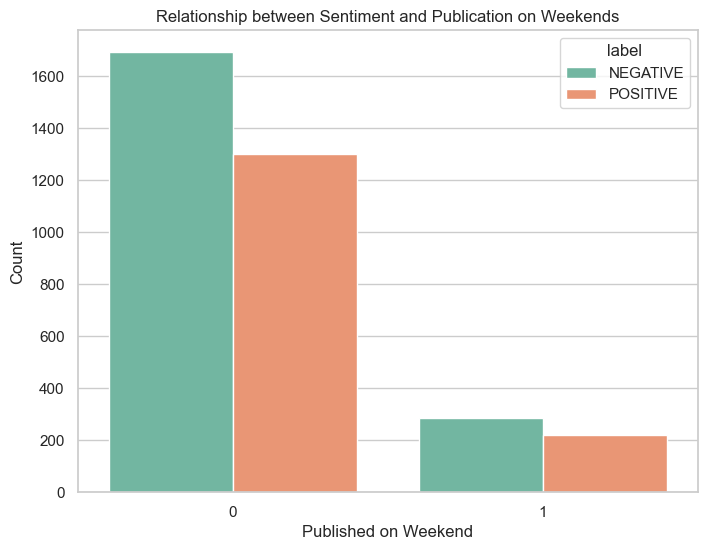

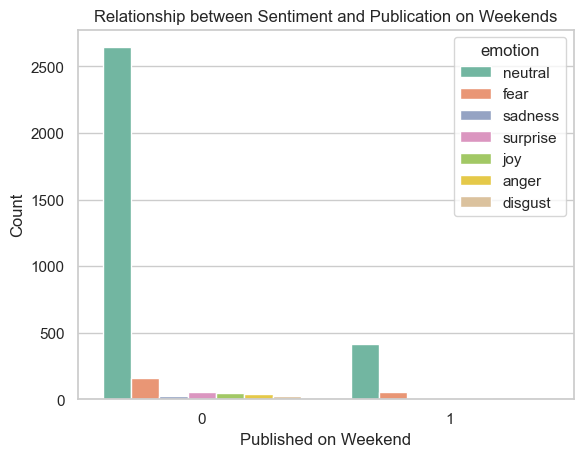

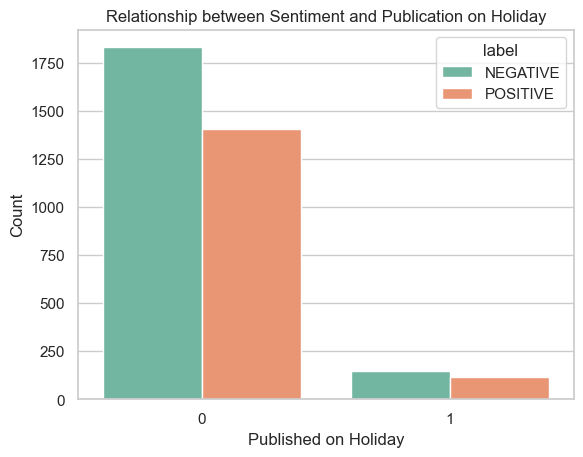

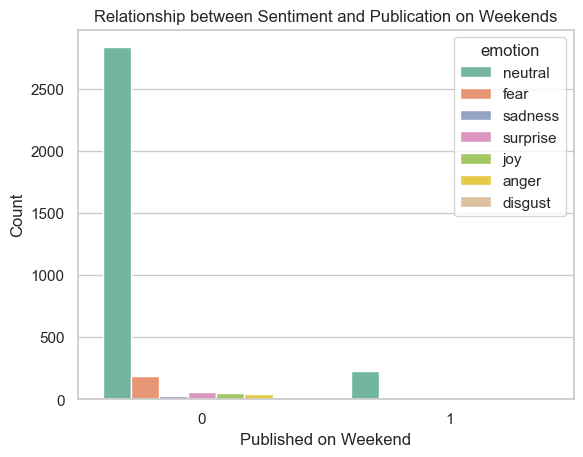

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a countplot to visualize the relationship - label vs.weekend
sns.countplot(x="is_weekend", hue="label", data=df, palette="Set2")

# Add labels and title
plt.xlabel("Published on Weekend")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Publication on Weekends")

# Show the plot
plt.show()

# Create a countplot to visualize the relationship - emotion vs.weekend
sns.countplot(x="is_weekend", hue="emotion", data=df, palette="Set2")

# Add labels and title
plt.xlabel("Published on Weekend")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Publication on Weekends")

# Show the plot
plt.show()

# Create a countplot to visualize the relationship
sns.countplot(x="is_holiday", hue="label", data=df, palette="Set2")

# Add labels and title
plt.xlabel("Published on Holiday")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Publication on Holiday")

# Show the plot
plt.show()

# Create a countplot to visualize the relationship - emotion vs.holiday
sns.countplot(x="is_holiday", hue="emotion", data=df, palette="Set2")

# Add labels and title
plt.xlabel("Published on Weekend")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Publication on Weekends")

# Show the plot
plt.show()

## Day in a week?

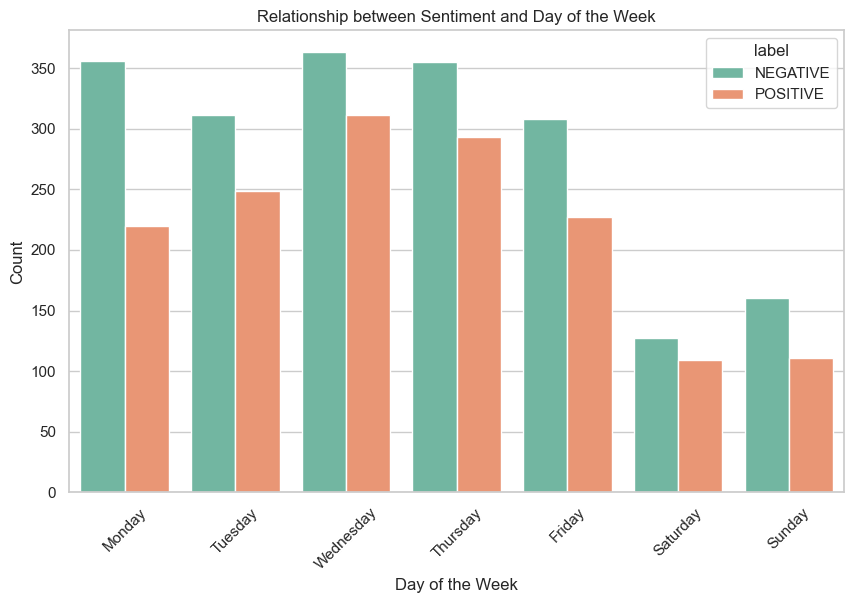

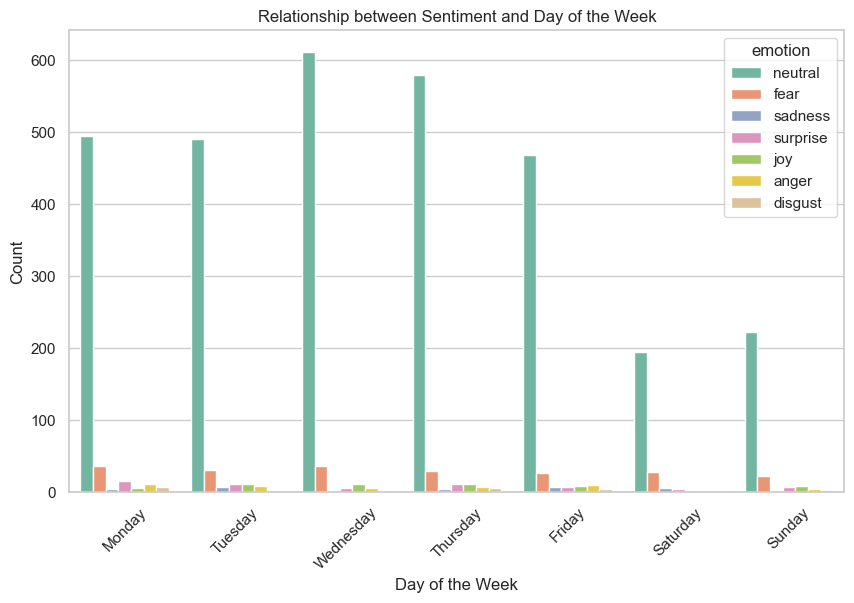

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a countplot to visualize the relationship
sns.countplot(x="day_of_week", hue="label", data=df, palette="Set2", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Add labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Day of the Week")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a countplot to visualize the relationship
sns.countplot(x="day_of_week", hue="emotion", data=df, palette="Set2", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

# Add labels and title
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.title("Relationship between Sentiment and Day of the Week")

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Month?


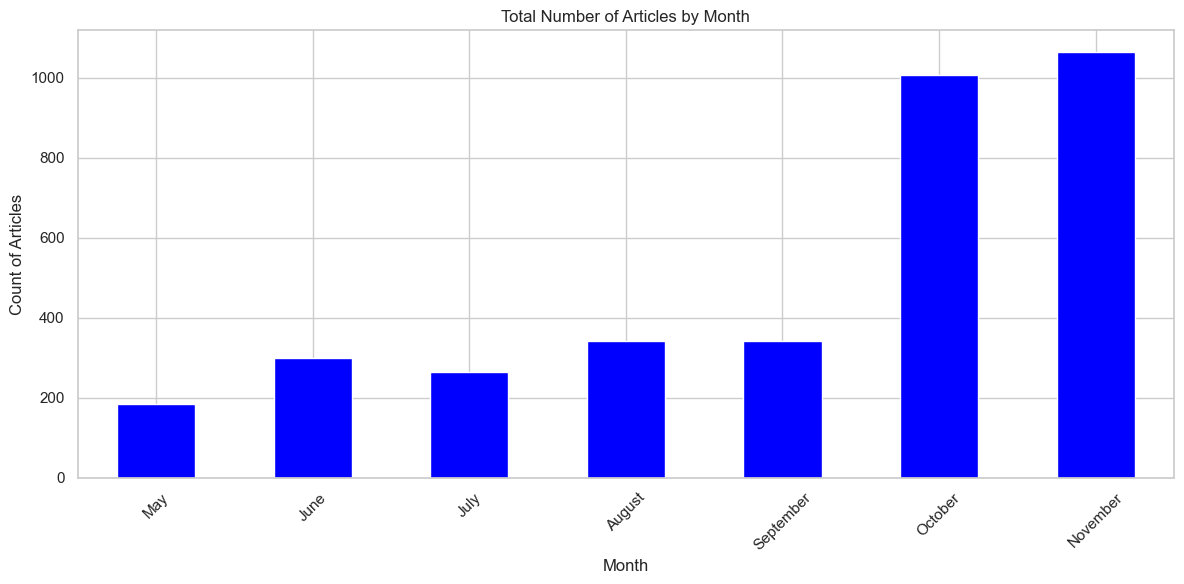

In [38]:
df['date'] = pd.to_datetime(df['date'])

# Group by month and count the total number of articles for each month
monthly_articles = df.groupby(df['date'].dt.to_period('M')).size()

# Convert the PeriodIndex to datetime to help with plotting
monthly_articles.index = monthly_articles.index.to_timestamp()

plt.figure(figsize=(12, 6))
monthly_articles.plot(kind='bar', color='blue')
plt.title('Total Number of Articles by Month')
plt.xlabel('Month')
plt.ylabel('Count of Articles')
plt.xticks(range(len(monthly_articles.index)), [calendar.month_name[i.month] for i in monthly_articles.index], rotation=45)
plt.tight_layout()
plt.show()


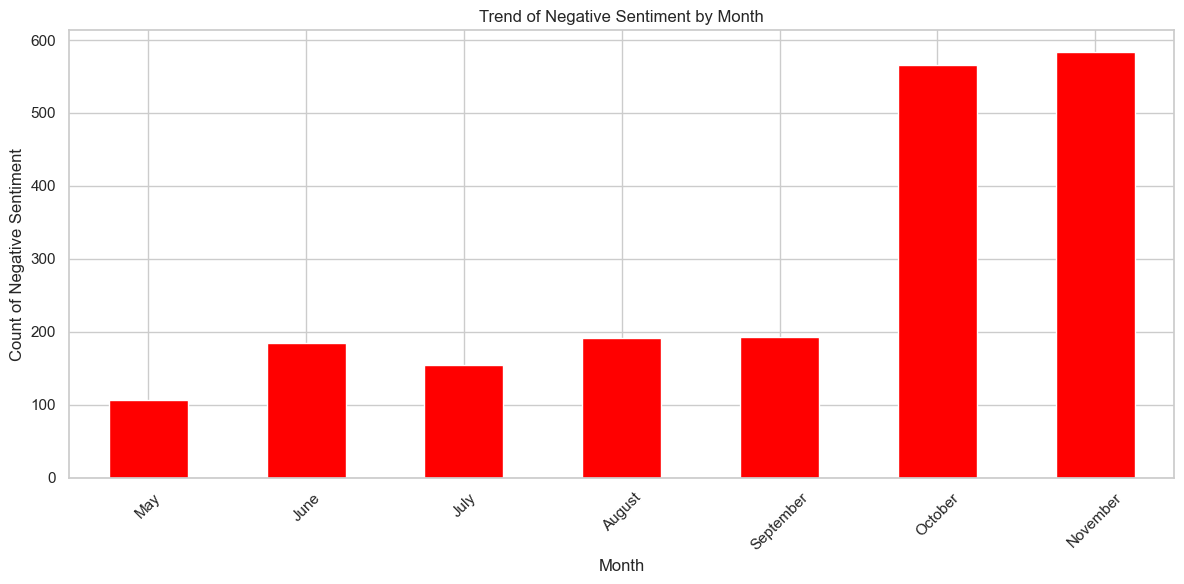

In [32]:
import matplotlib.pyplot as plt
import calendar

df['date'] = pd.to_datetime(df['date'])

# Filter out the data with negative sentiment
negative_data = df[df['label'] == 'NEGATIVE']

# Group by month and count the number of negative sentiments for each month
negative_trend = negative_data.groupby(negative_data['date'].dt.to_period('M')).size()

# Convert the PeriodIndex to datetime to help with plotting
negative_trend.index = negative_trend.index.to_timestamp()

plt.figure(figsize=(12, 6))
negative_trend.plot(kind='bar', color='red')


plt.title('Trend of Negative Sentiment by Month')
plt.xlabel('Month')
plt.ylabel('Count of Negative Sentiment')


plt.xticks(range(len(negative_trend.index)), [calendar.month_name[i.month] for i in negative_trend.index], rotation=45)

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

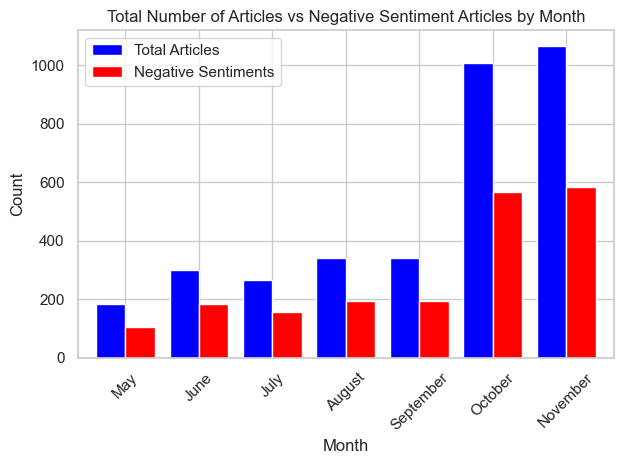

In [41]:
# Since the data has already been grouped by month for the total count of articles, we'll do the same for negative counts.
# Then, we will create a combined plot with two bars for each month, one for the total articles and one for negative sentiment articles.

# We have already grouped by month for negative sentiments, now we will align both dataframes for plotting
combined_df = pd.DataFrame({'Total Articles': monthly_articles, 'Negative Sentiments': negative_trend}).fillna(0)

# Plot
plt.figure(figsize=(12, 6))

# Plotting the total articles and negative sentiments side by side
combined_df.plot(kind='bar', color=['blue', 'red'], width=0.8, position=0.5)

# Set the title and labels
plt.title('Total Number of Articles vs Negative Sentiment Articles by Month')
plt.xlabel('Month')
plt.ylabel('Count')

# Formatting the x-axis with the month names
plt.xticks(range(len(combined_df.index)), [calendar.month_name[i.month] for i in combined_df.index], rotation=45)

# Show the plot
plt.tight_layout()
plt.legend(['Total Articles', 'Negative Sentiments'])
plt.show()


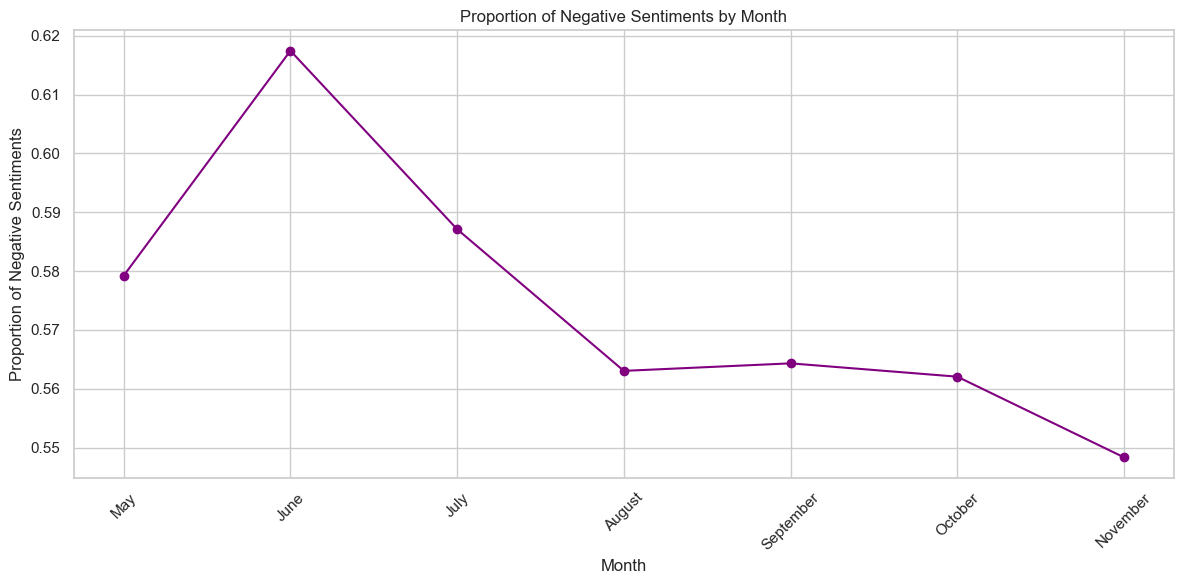

In [43]:
proportion_negative = combined_df['Negative Sentiments'] / combined_df['Total Articles']
month_labels = [calendar.month_name[i.month] for i in proportion_negative.index]

plt.figure(figsize=(12, 6))
plt.plot(month_labels, proportion_negative, marker='o', linestyle='-', color='purple')

# Set the title and labels
plt.title('Proportion of Negative Sentiments by Month')
plt.xlabel('Month')
plt.ylabel('Proportion of Negative Sentiments')

# Add grid lines for better readability
plt.grid(True)

# Show the plot with proper rotation for month labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


For better VISUAL INSPECTION, neutral sentiments have been excluded from the chart below, as the frequency of neutral sentiments is the majority regardless of the month in which they occur

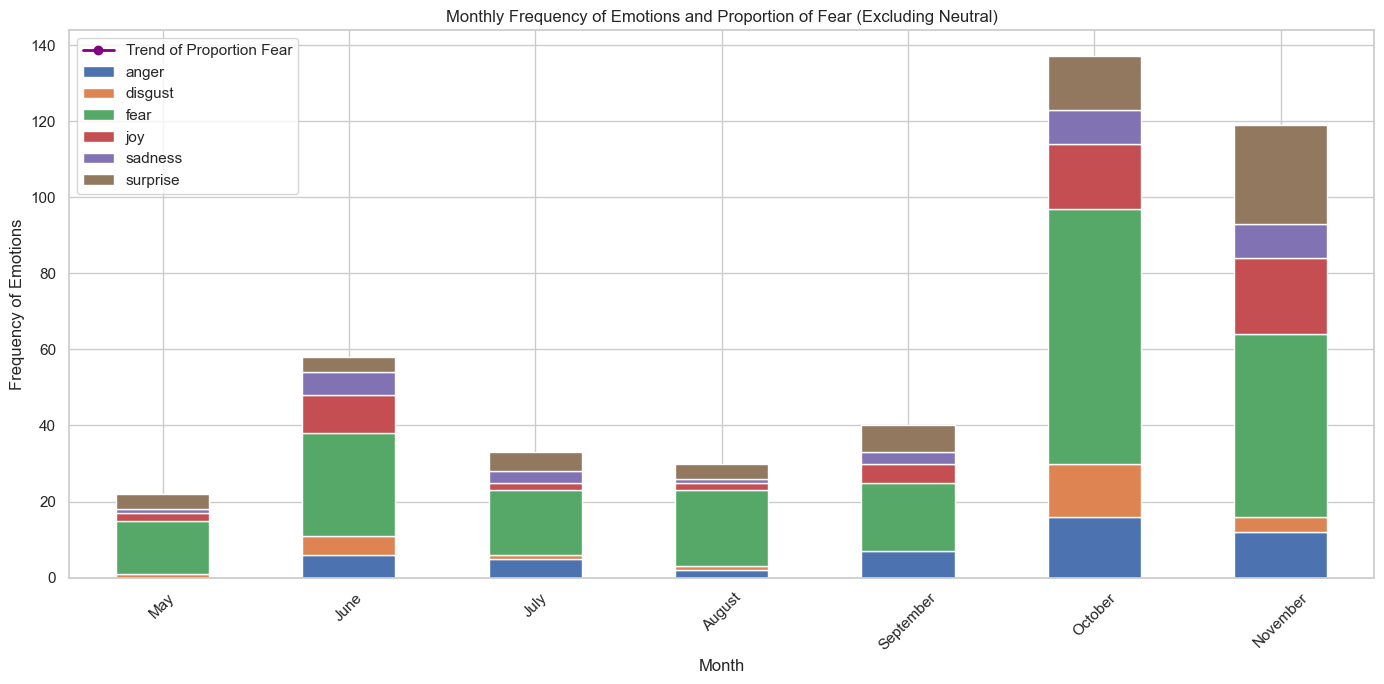

In [69]:
monthly_emotion_counts = df[df['emotion'] != 'neutral'].groupby([df['date'].dt.to_period('M'), 'emotion']).size().unstack('emotion').fillna(0)
# monthly_emotion_counts['proportion_fear'] = monthly_emotion_counts['fear'] / monthly_emotion_counts.sum(axis=1)
# emotion_counts_without_proportion = monthly_emotion_counts.drop(columns='proportion_fear')

# Create figure and plot bar
fig, ax = plt.subplots(figsize=(14, 7))

emotion_counts_without_proportion.plot(kind='bar', stacked=True, ax=ax)
ax.plot(monthly_emotion_counts.index.to_timestamp(), fear_proportion, color='purple', marker='o', linewidth=2, label='Trend of Proportion Fear')

ax.set_title('Monthly Frequency of Emotions and Proportion of Fear (Excluding Neutral)')
ax.set_xlabel('Month')
ax.set_ylabel('Frequency of Emotions')
ax.grid(True)

ax.set_xticks(range(len(emotion_counts_without_proportion.index)))
ax.set_xticklabels(month_labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()


## 2. classifier

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [19]:
!pip install --upgrade scikit-learn

In [20]:
# determin X and Y
X = df['tokenized_title']  # Text data
y = df['label']  # Sentiment levels

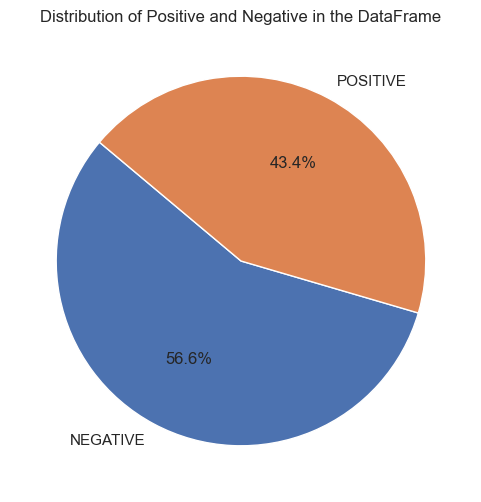

In [21]:
# Counting the occurrences of 0 and 1
counts = df['label'].value_counts()

# Labels for the classes
labels_df = counts.index

# Creating the pie chart for the DataFrame
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels_df, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Positive and Negative in the DataFrame')
plt.show()

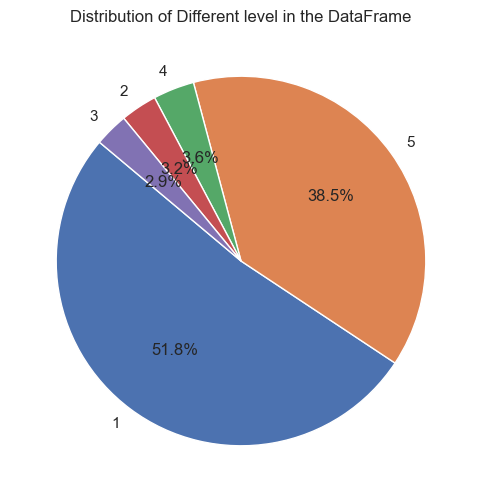

In [22]:
# Counting the occurrences of 0 and 1
counts = df['level'].value_counts()

# Labels for the classes
labels_df = counts.index

# Creating the pie chart for the DataFrame
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels_df, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Different level in the DataFrame')
plt.show()

## 2.1 Naive Bayes

In [23]:
from transformers import BertTokenizer, BertModel
import torch

# Initialize tokenizer and model from pre-trained 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(sentences):
    """Converts sentences to BERT embeddings."""
    inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings for the [CLS] token
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Accuracy: 0.7142857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76       394
           1       0.72      0.58      0.64       306

    accuracy                           0.71       700
   macro avg       0.71      0.70      0.70       700
weighted avg       0.71      0.71      0.71       700



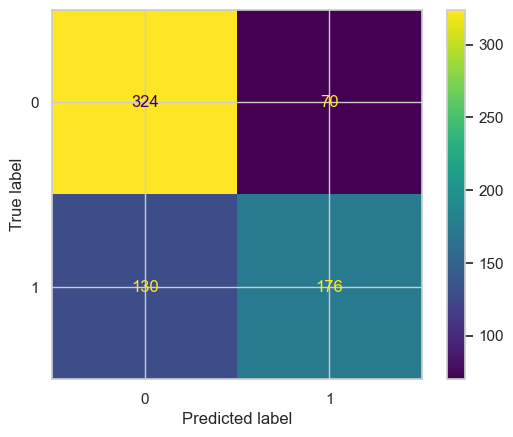

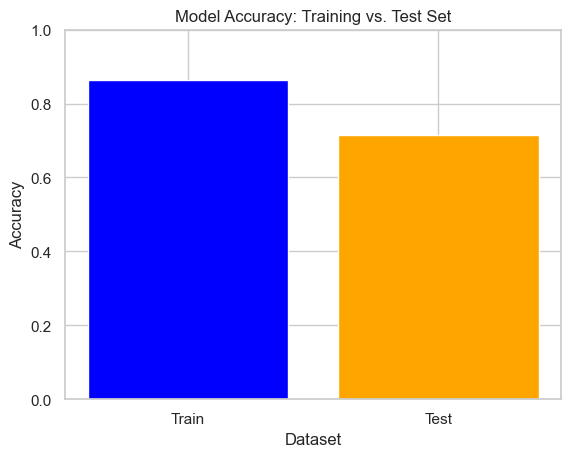

In [24]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Join the list of headlines into a single string for each document
X_train_str = [' '.join(text) for text in X_train]
X_test_str = [' '.join(text) for text in X_test]

# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer( max_features=3150,max_df = 0.3, ngram_range = (1,6),stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)


# Choose a Naive Bayes classifier (Multinomial Naive Bayes)
nb_classifier = MultinomialNB(alpha = 1)
nb_classifier.fit(X_train_tfidf, y_train)

# Predictions
y_pred = nb_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
confusion = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()


y_train_pred = nb_classifier.predict(X_train_tfidf)
# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

categories = ['Train', 'Test']
accuracies = [train_accuracy, accuracy]

# Plotting the histogram
plt.bar(categories, accuracies, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Training vs. Test Set')
plt.ylim(0, 1)  # Setting the limit for clearer comparison
plt.show()


## 2.2 Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.6685714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.87      0.75       394
           1       0.71      0.41      0.52       306

    accuracy                           0.67       700
   macro avg       0.68      0.64      0.63       700
weighted avg       0.68      0.67      0.65       700



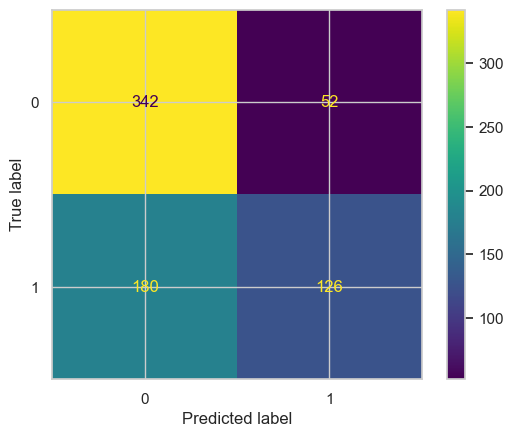

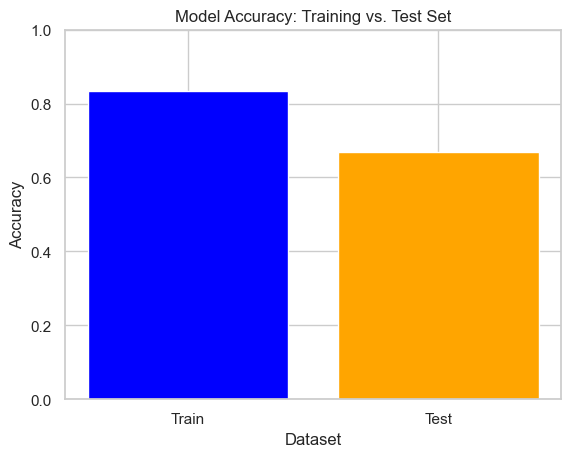

In [26]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Join the list of headlines into a single string for each document
X_train_str = [' '.join(text) for text in X_train]
X_test_str = [' '.join(text) for text in X_test]

#  TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3100, ngram_range = (1,5), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

# X_train_tfidf = get_bert_embeddings(X_train_str)
# X_test_tfidf = get_bert_embeddings(X_test_str)


# Random Forest as classifier
clf = RandomForestClassifier(n_estimators= 300, min_samples_split = 3, min_samples_leaf = 2, max_depth = 88,random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_rep)

# Plot confusion matrix
confusion = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot()
plt.show()

y_train_pred = clf.predict(X_train_tfidf)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

categories = ['Train', 'Test']
accuracies = [train_accuracy, accuracy]

# Plotting the histogram
plt.bar(categories, accuracies, color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Model Accuracy: Training vs. Test Set')
plt.ylim(0, 1) 
plt.show()

# 2.3 NeuralNet

Epoch 1/15
35/35 - 1s - loss: 0.7167 - accuracy: 0.5406 - val_loss: 0.6832 - val_accuracy: 0.5643 - 928ms/epoch - 27ms/step
Epoch 2/15
35/35 - 0s - loss: 0.7172 - accuracy: 0.5411 - val_loss: 0.6783 - val_accuracy: 0.5589 - 406ms/epoch - 12ms/step
Epoch 3/15
35/35 - 0s - loss: 0.6933 - accuracy: 0.5754 - val_loss: 0.6731 - val_accuracy: 0.5714 - 397ms/epoch - 11ms/step
Epoch 4/15
35/35 - 0s - loss: 0.6461 - accuracy: 0.6210 - val_loss: 0.6508 - val_accuracy: 0.6268 - 401ms/epoch - 11ms/step
Epoch 5/15
35/35 - 0s - loss: 0.5974 - accuracy: 0.6862 - val_loss: 0.6085 - val_accuracy: 0.6821 - 400ms/epoch - 11ms/step
Epoch 6/15
35/35 - 0s - loss: 0.4822 - accuracy: 0.7799 - val_loss: 0.6088 - val_accuracy: 0.6804 - 399ms/epoch - 11ms/step
Epoch 7/15
35/35 - 0s - loss: 0.3743 - accuracy: 0.8371 - val_loss: 0.6263 - val_accuracy: 0.6696 - 400ms/epoch - 11ms/step
Epoch 8/15
35/35 - 0s - loss: 0.3154 - accuracy: 0.8714 - val_loss: 0.6698 - val_accuracy: 0.6643 - 402ms/epoch - 11ms/step
Epoch 9/

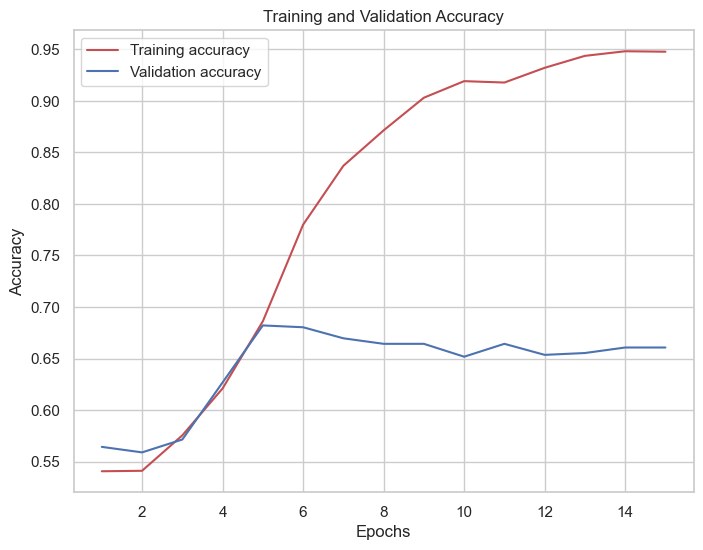

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam

# Since we're using a dense network, we need to convert the sparse matrix to a dense format
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Define the model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    Dropout(0.6),
    
    Dense(128, activation='relu'),
    Dropout(0.7),
    
    Dense(64, activation='relu'),
    Dropout(0.7),
    
    Dense(2, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_dense, y_train_one_hot,
                    batch_size = 64,
                    epochs = 15, 
                    verbose = 2,
                    validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_dense, y_test_one_hot, verbose=1)
print(f'Test Accuracy: {test_accuracy}')

history_dict = history.history

# Extracting the accuracy and validation accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# You can further analyze the performance using metrics like precision, recall, f1-score, etc., similar to your Naive Bayes model.


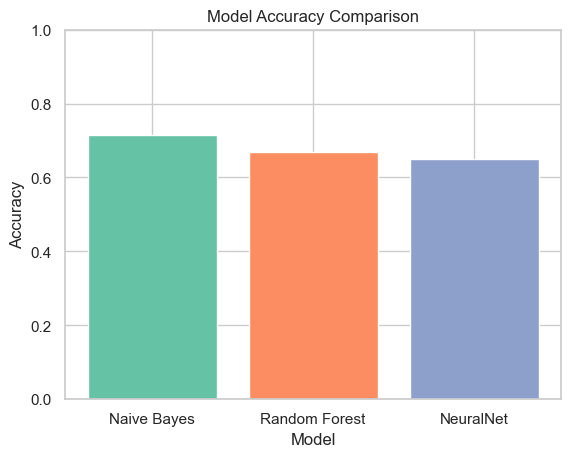

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fetching the "Set2" palette colors
palette_colors = sns.color_palette("Set2", 3)  # '3' for the number of unique colors you need

# Sample data
models = ['Naive Bayes', 'Random Forest', 'NeuralNet']
accuracies = [0.7143, 0.6686, 0.65]

# Creating the histogram with matplotlib, using colors from the "Set2" palette
plt.bar(models, accuracies, color=palette_colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()
